## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
# import all required libraries
import numpy as np
import cv2
import glob
import math
import time
import pickle
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from multi_plot import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import scipy.ndimage as snd
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

%matplotlib inline

Number of car files:  8807
Number of non-car files:  8968


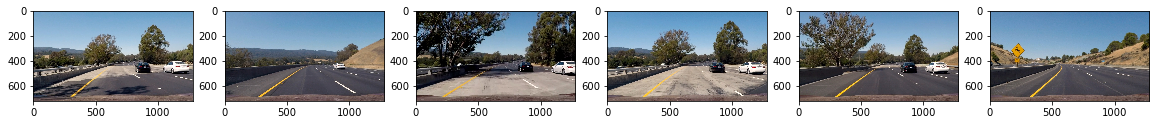

In [2]:
test_files = glob.glob('./test_images/*.jpg')
car_files = glob.glob('vehicles/**/*.png', recursive=True)
print("Number of car files: ", len(car_files))
notcar_files = glob.glob('non_vehicles/**/*.png', recursive=True)
print("Number of non-car files: ", len(notcar_files))
output_folder = './output_images/'

test_images = []
for fname in test_files:
    img = snd.imread(fname)
    test_images.append(img)
    
plot_images(test_images, n_cols=6)

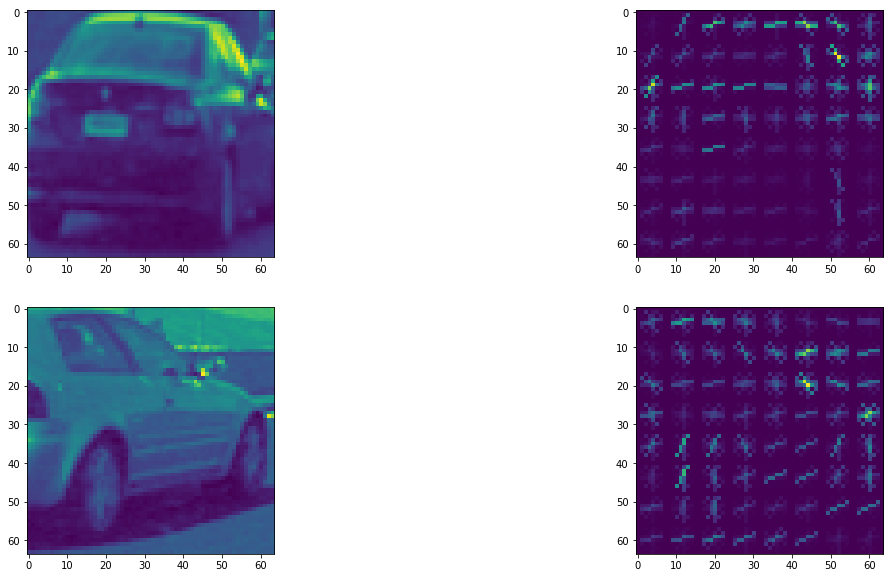

In [3]:
%run feature_extraction.py
example_cars = [snd.imread(file)[:,:,1] for file in car_files[0:2]]
example_notcars = [snd.imread(file) for file in notcar_files[0:2]]

example_hog_cars=[]
for img in example_cars:
    hog_features, hog_img = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    example_hog_cars.append(hog_img)

plot_compare_images(example_cars, example_hog_cars)

In [12]:
%run feature_extraction.py
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = min(len(car_files), len(notcar_files))
print("Sample size:", sample_size)
cars = car_files[0:sample_size]
notcars = notcar_files[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

def train_svc():
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    X = np.vstack((car_features, notcar_features)).astype(np.float32) 
    print(X.shape)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    del X

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    return svc, X_scaler

svc, X_scaler = train_svc()

Sample size: 8807
(17614, 6252)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6252
2.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


In [13]:
# save SVM data
def save_classifier(file='svm.p'):
    print('Saving classification data to pickle file...')
    try:
        with open(file, 'wb') as pfile:
            pickle.dump(
                {   'svc':svc, 
                    'X_scaler': X_scaler,
                    'color_space': color_space,
                    'spatial_size': spatial_size,
                    'hist_bins': hist_bins,
                    'orient': orient,
                    'pix_per_cell': pix_per_cell,
                    'cell_per_block': cell_per_block,
                    'hog_channel': hog_channel,
                    'spatial_feat': spatial_feat,
                    'hist_feat': hist_feat,
                    'hog_feat':hog_feat
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Error saving pickle file', file, ':', e)
        raise
        
def load_classifier(file='svm.p'):
    print('Load classification data from pickle file...')
    try:
        with open(file, "rb") as pfile:
            data = pickle.load(input_file)
            svc = data['svc']
            X_scaler = data['X_scaler']
            spatial_size =  data['spatial_size']
            hist_bins = data['hist_bins']
            orient = data['orient']
            pix_per_cell = data['pix_per_cell']
            cell_per_block = data['cell_per_block']
            hog_channel = data['hog_channel']
            spatial_feat = data['spatial_feat']
            hist_feat = data['hist_feat']
            hog_feat = data['hog_feat']         
                
    except Exception as e:
        print('Error loading pickle file', file, ':', e)
        raise   

(1, 6252)


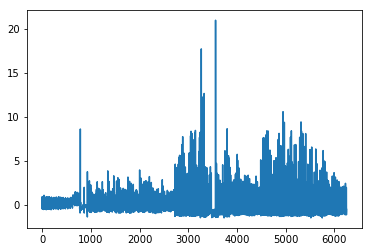

4.25 Seconds to find car windows...


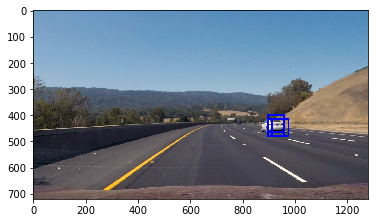

In [14]:
%run feature_extraction.py
image = snd.imread(test_files[1])
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, 680] # Min and max in y to search in slide_window()
window_sizes=[(64, 128)]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))


windows = []
for w in range(64, 128, 64):
    win = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, \
                       xy_window=(w, w), xy_overlap=(0.75, 0.75))
    windows += win
    
t=time.time()
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find car windows...')

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

3.66 Seconds to find car windows...


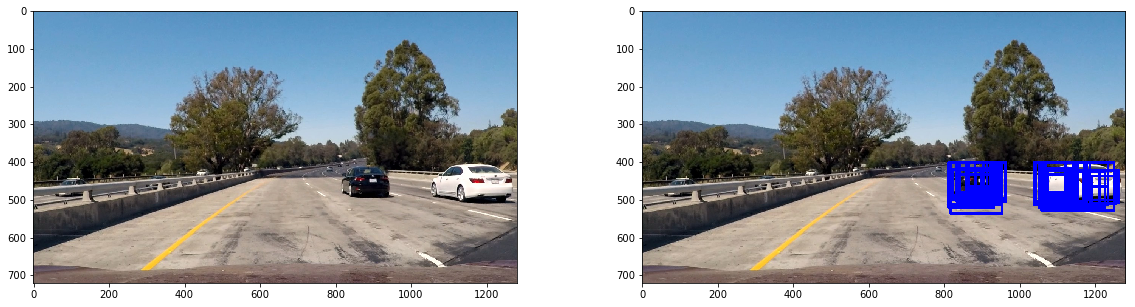

In [15]:
%run feature_extraction.py
image = snd.imread(test_files[3])
draw_image = np.copy(image)
t=time.time()
hot_boxes = []
for scale in np.arange(1., 2.5, 0.125):
    out_img, boxes = find_cars(image, y_start_stop[0], y_start_stop[1], scale, \
                                 svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_boxes += boxes
    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find car windows...')

window_img = draw_boxes(draw_image, hot_boxes, color=(0, 0, 255), thick=6) 
plot_compare_images([image], [window_img])

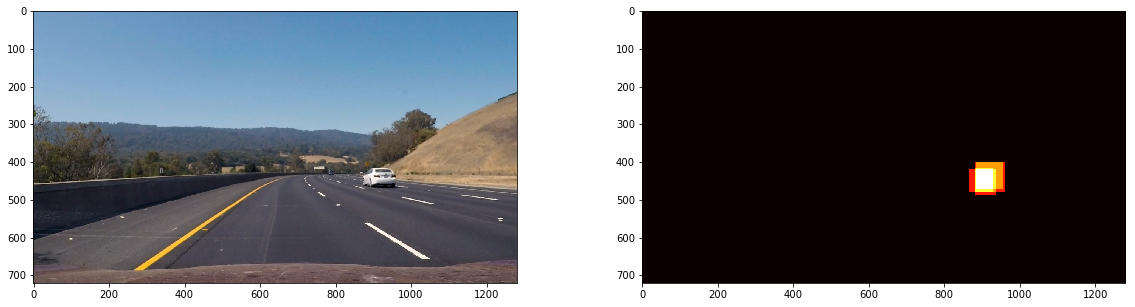

In [8]:
%run feature_extraction.py
%run box.py

box = Box(image, hot_boxes)
heatmap = box.heatmap

# Find final boxes from heatmap using label function
heat_img = box.draw_final(image)

plot_compare_images([image], [heatmap], cmap='hot')

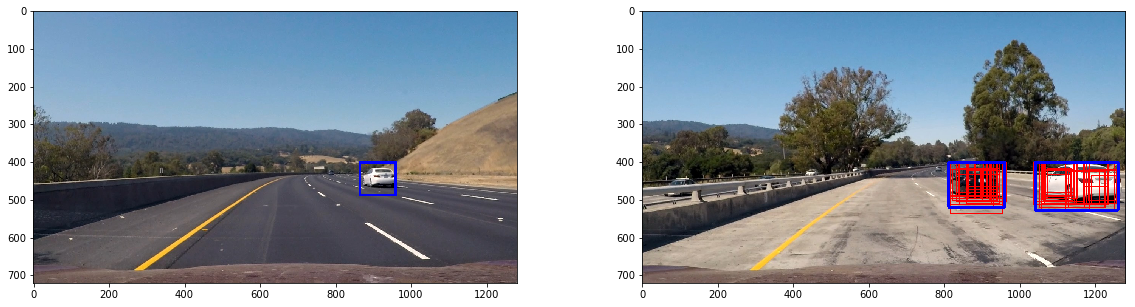

In [16]:
#hot_boxes = []
def process_image(image):
    draw_image = np.copy(image)
    hot_boxes = []
    window_scales = np.linspace(1.,2.5,13)
    for scale in window_scales:
        out_img, boxes = find_cars(image, y_start_stop[0], y_start_stop[1], scale, \
                                     svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        hot_boxes += boxes
    car_boxes = Box(image, hot_boxes)
    #hot_img = np.dstack((np.zeros_like(car_boxes.heatmap), np.zeros_like(car_boxes.heatmap), np.zeros_like(car_boxes.heatmap)))
    draw_image = car_boxes.draw_hot(draw_image)
    return car_boxes.draw_final(draw_image)

box_img = process_image(image)
plot_compare_images([heat_img], [box_img])

In [17]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False).subclip(29,30)
#clip1 = VideoFileClip("challenge_video.mp4", audio=False).subclip(0,3)
white_clip = clip1.fl_image(process_image)
#white_clip.write_images_sequence("scene%i.jpg")
#white_clip.save_frame("frame.jpeg", t='00:00:500') 
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 96%|█████████▌| 25/26 [01:32<00:03,  3.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 48s, sys: 188 ms, total: 1min 48s
Wall time: 1min 33s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))